## Construccion de un VP-tree

### Paso 1
Se selecciona un punto pivote de máxima diversidad, el pivote va a variar dependiendo del algoritmo implementado, en este caso estamos usando una aproximación en la que se consigue una muestra aleatoria $m$ de la cantidad de puntos $n$ tal que $m <<< n$

por lo que la complejidad esperada de este paso sería $O(nm)$ y dado que $m$ se considera constante entonces la complejidad tiende a $O(n)$

### Paso 2

Luego de determinado el pivote se procede a hacer la division de los datos uno a uno lo que tiene complejidad $O(n)$

### Paso 3
Se repite recursivamente para el arbol de la derecha como de la izquierda teniendo complejidad esperada de $O(log(n))$


En total la construcción del árbol tiene complejidad $O(nlog(n))$ cuando $m$ es constante

In [1]:
import heapq
import numpy as np
def euclidean_distance(a, b):
	return np.linalg.norm(a - b)

## Búsqueda de k vecinos cercanos

Para esto se usa la siguiente función:


In [2]:
def search_knn(target, node, k, heap):
    if node is None:
        return

    distance = euclidean_distance(target, node.point)
    
    if len(heap) < k:
        heapq.heappush(heap, (-distance, node.point))
    else:
        if distance < -heap[0][0]:
            heapq.heappushpop(heap, (-distance, node.point))

    if distance < node.threshold:
        search_knn(target, node.left, k, heap)
        if (distance + (-heap[0][0])) >= node.threshold:  
            search_knn(target, node.right, k, heap)
    else:
        search_knn(target, node.right, k, heap)
        if (distance - (-heap[0][0])) <= node.threshold:
            search_knn(target, node.left, k, heap)

### Propiedades de la distancia en un espacio métrico
- $d(x,x) = 0$
- Si $x \neq y$ entonces $d(x,y) > 0$
- $d(x,y) = d(y,x)$
- $d(x,z) \leq d(x,y) + d(y,z)$

### ¿Cómo funciona la poda?

Para esto se usa la desigualdad triangular. Sea:
- target: El nodo al cual se le buscan los k vecinos más cercanos
- pivot: El punto el cual se va a comparar con target
- p: Punto de referencia con respecto a pivot 
- wd: Vecino obtenido con mayor distancia

De 
$$
d(p,pivot) \leq d(p,target) + d(target,pivot)
$$

Obtenemos

$$
dist(p, target) \geq |dist(p, pivot) - dist(pivot, target)|        ...(1)
$$

Para el caso del target en el subárbol cercano se tiene:
- $dist(pivot, target) < threshold$
- $threshold < dist(p, pivot)$

Entonces $dist(pivot, target) < threshold < dist(p, pivot)$

Luego, (1) se convierte en:
$$
dist(p, target) \geq dist(p, pivot) - dist(pivot, target) 
$$

$$
dist(p, target) \geq dist(p, pivot) - dist(pivot, target) \geq threshold - distance 
$$

Entonces, si $threshold - distance \geq wd$, no puede haber un punto en el subárbol lejano que pueda entrar en el grupo de k vecinos.

Para el caso del target en el subárbol lejano se tiene:
- $dist(pivot, target) \geq threshold$
- $threshold > dist(p, pivot)$

Luego, (1) se convierte en:
$$
dist(p, target) \geq dist(pivot, target) - dist(p, pivot)  
$$

$$
dist(p, target) \geq dist(pivot, target) - dist(p, pivot) \geq distance - threshold 
$$

Entonces, si $distance - threshold \geq wd$, no puede haber un punto en el subárbol cercano que pueda entrar en el grupo de k vecinos.




## Búsqueda en una región de radio k

Para esto se usa la siguiente función:

In [3]:
def region_search(node, target, radius, results):
    if node is None:
        return

    d = euclidean_distance(target, node.point)
    if d <= radius:
        results.append(node.point)

    if d < node.threshold:
        region_search(node.left, target, radius, results)
        if d + radius >= node.threshold:
            region_search(node.right, target, radius, results)
    else:
        region_search(node.right, target, radius, results)
        if d - radius <= node.threshold:
            region_search(node.left, target, radius, results)



## Profiling

### Construcción del VP-Tree

Probando con 100 puntos...
Probando con 500 puntos...
Probando con 1000 puntos...
Probando con 1500 puntos...
Probando con 2000 puntos...
Probando con 2500 puntos...
Probando con 3000 puntos...
Probando con 3500 puntos...
Probando con 4000 puntos...
Probando con 4500 puntos...
Probando con 5000 puntos...
Probando con 5500 puntos...
Probando con 6000 puntos...


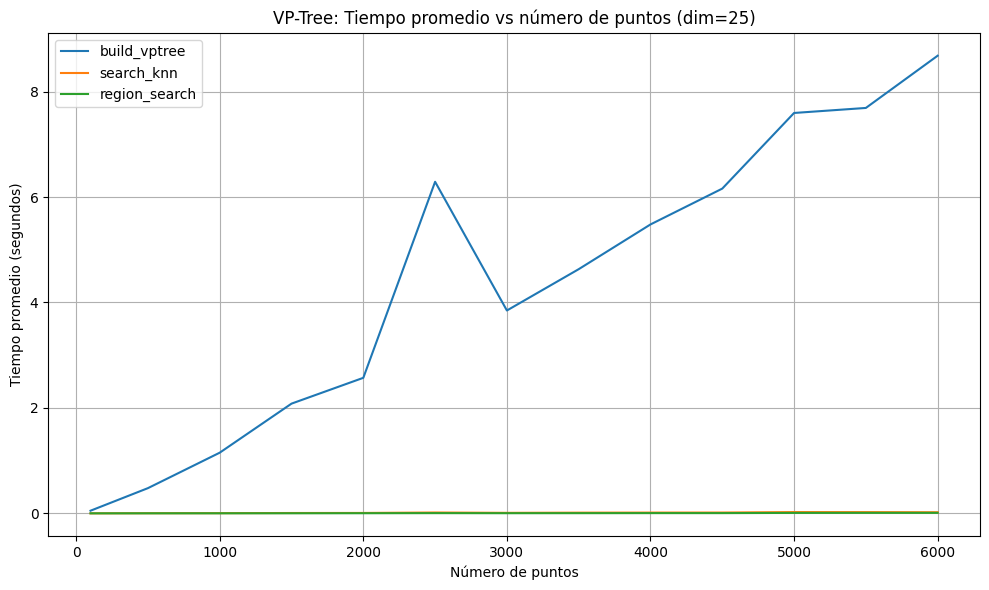

In [6]:
import time
import numpy as np
import matplotlib.pyplot as plt
from vptree import build_vptree, search_knn, region_search, euclidean_distance
import heapq

# Configuración de prueba
NUM_TRIALS = 5
POINT_COUNTS = [100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000]
DIM = 25
K = 4
RADIUS = 0.5

# Almacenar resultados
build_times = []
knn_times = []
region_times = []

for n_points in POINT_COUNTS:
    print(f"Probando con {n_points} puntos...")

    total_build = 0.0
    total_knn = 0.0
    total_region = 0.0

    for _ in range(NUM_TRIALS):
        points = [np.random.rand(DIM) for _ in range(n_points)]
        query = np.full(DIM, 0.5)

         # Tiempo de construcción
        start = time.perf_counter()
        tree = build_vptree(points)
        total_build += time.perf_counter() - start

        # Tiempo de knn
        heap = []
        start = time.perf_counter()
        search_knn(query, tree, K, heap)
        total_knn += time.perf_counter() - start

        # Tiempo de region search
        results = []
        start = time.perf_counter()
        region_search(tree, query, RADIUS, results)
        total_region += time.perf_counter() - start

    build_times.append(total_build / NUM_TRIALS)
    knn_times.append(total_knn / NUM_TRIALS)
    region_times.append(total_region / NUM_TRIALS)

plt.figure(figsize=(10, 6))
plt.plot(POINT_COUNTS, build_times, label='build_vptree')
plt.plot(POINT_COUNTS, knn_times, label='search_knn')
plt.plot(POINT_COUNTS, region_times, label='region_search')
plt.xlabel('Número de puntos')
plt.ylabel('Tiempo promedio (segundos)')
plt.title(f'VP-Tree: Tiempo promedio vs número de puntos (dim={DIM})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### KNN y region search

Probando con 100 puntos...
Probando con 200 puntos...
Probando con 300 puntos...
Probando con 500 puntos...
Probando con 1000 puntos...
Probando con 1500 puntos...
Probando con 2000 puntos...
Probando con 2500 puntos...
Probando con 3000 puntos...
Probando con 3500 puntos...
Probando con 4000 puntos...
Probando con 4500 puntos...
Probando con 5000 puntos...
Probando con 5500 puntos...
Probando con 6000 puntos...
Probando con 6500 puntos...


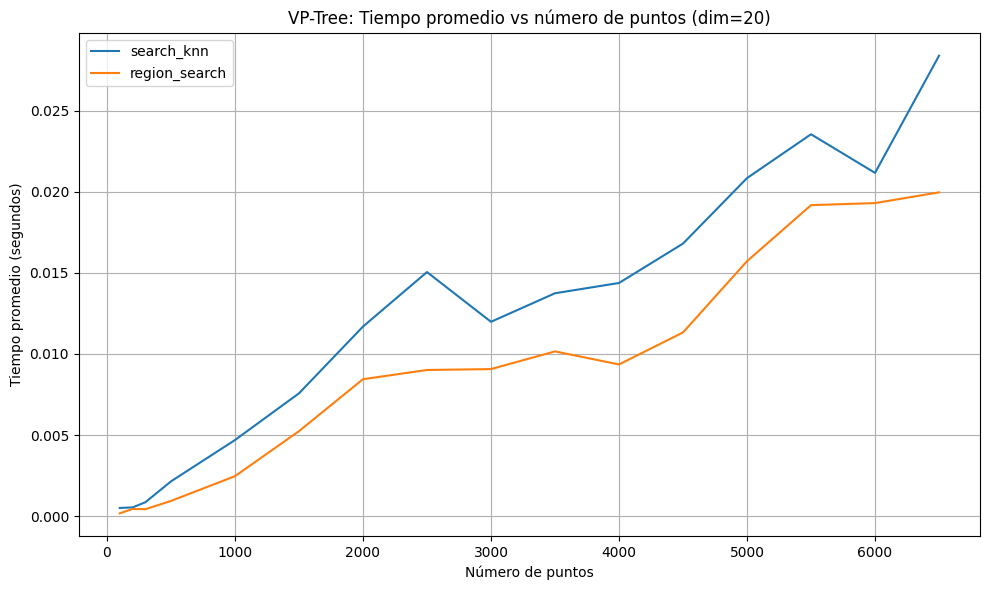

In [11]:
import time
import numpy as np
import matplotlib.pyplot as plt
from vptree import build_vptree, search_knn, region_search, euclidean_distance
import heapq

# Configuración de prueba
NUM_TRIALS = 5
POINT_COUNTS = [100, 200, 300, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500]
DIM = 20
K = 5
RADIUS = 0.5

# Almacenar resultados
build_times = []
knn_times = []
region_times = []

for n_points in POINT_COUNTS:
    print(f"Probando con {n_points} puntos...")

    total_build = 0.0
    total_knn = 0.0
    total_region = 0.0

    points = [np.random.rand(DIM) for _ in range(n_points)]
    tree = build_vptree(points)
    
    for _ in range(NUM_TRIALS):
        query = np.full(DIM, 0.5)

         # Tiempo de construcción
        start = time.perf_counter()
        
        total_build += time.perf_counter() - start

        # Tiempo de k-NN
        heap = []
        start = time.perf_counter()
        search_knn(query, tree, K, heap)
        total_knn += time.perf_counter() - start

        # Tiempo de búsqueda por rango
        results = []
        start = time.perf_counter()
        region_search(tree, query, RADIUS, results)
        total_region += time.perf_counter() - start

        points = [np.random.rand(DIM) for _ in range(n_points)]

    build_times.append(total_build / NUM_TRIALS)
    knn_times.append(total_knn / NUM_TRIALS)
    region_times.append(total_region / NUM_TRIALS)

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(POINT_COUNTS, knn_times, label='search_knn')
plt.plot(POINT_COUNTS, region_times, label='region_search')
plt.xlabel('Número de puntos')
plt.ylabel('Tiempo promedio (segundos)')
plt.title(f'VP-Tree: Tiempo promedio vs número de puntos (dim={DIM})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## KD-Tree importado del material de clase

In [12]:
import math

class Point:
    """
    Representa un punto en un espacio k-dimensional 
    """
    def __init__(self, coordinates):
        """
        Inicializa un punto con una lista o tupla de coordenadas.
        :param coordinates: Lista o tupla de números (coordenadas).
        """
        if not isinstance(coordinates, (list, tuple)):
            raise TypeError("Las coordenadas deben ser una lista o tupla")
        # Almacena como tupla de flotantes para inmutabilidad y precisión.
        self._coordinates = tuple(float(c) for c in coordinates)
        self.dimensionality = len(self._coordinates)

    def coordinate(self, dim_index):
        """
        Obtiene la coordenada en una dimensión específica.
        :param dim_index: Índice de la dimensión (0 para x, 1 para y, etc.).
        :return: El valor de la coordenada.
        :raises IndexError: Si el índice está fuera de rango.
        """
        if not 0 <= dim_index < self.dimensionality:
            raise IndexError("Índice de dimensión fuera de rango")
        return self._coordinates[dim_index]

    def distanceTo(self, other_point):
        """
        Calcula la distancia euclidiana a otro punto.
        :param other_point: Otro objeto Point.
        :return: La distancia euclidiana.
        :raises ValueError: Si los puntos no tienen la misma dimensionalidad.
        """
        if self.dimensionality != other_point.dimensionality:
            raise ValueError("Los puntos deben tener la misma dimensionalidad para calcular la distancia")
        dist_sq = sum((s - o)**2 for s, o in zip(self._coordinates, other_point._coordinates))
        return math.sqrt(dist_sq)

    def __eq__(self, other):
        """
        Compara si dos puntos son iguales (misma dimensionalidad y coordenadas).
        """
        if not isinstance(other, Point):
            return NotImplemented
        return self._coordinates == other._coordinates

    # Mantenemos 'equals' como alias de __eq__ para compatibilidad con versiones anteriores
    def equals(self, other_point):
        """
        (Alias) Comprueba si este punto es igual a otro.
        :param other_point: Otro objeto Point.
        :return: True si son el mismo punto, False en caso contrario.
        """
        return self == other_point

    def __hash__(self):
        """
        Genera un hash para el punto, permitiendo su uso en sets o como claves de diccionario.
        """
        return hash(self._coordinates)

    @property
    def coordinates(self):
        """Propiedad para acceder a las coordenadas como tupla."""
        return self._coordinates

    def __getitem__(self, index):
        """Permite acceder a las coordenadas usando p[dim]."""
        return self.coordinate(index)

    def __len__(self):
        """Devuelve la dimensionalidad del punto."""
        return self.dimensionality

    @staticmethod
    def validatePointArray(points, expected_dimensionality, context):
        """Valida una lista de puntos."""
        if not isinstance(points, list):
            raise TypeError(f"{context}: Se esperaba una lista de puntos.")
        for p in points:
            Point.validatePoint(p, expected_dimensionality, context)
        if points and expected_dimensionality is None:
            expected_dimensionality = points[0].dimensionality
        if points:
            for p in points:
                if p.dimensionality != expected_dimensionality:
                    raise ValueError(f"{context}: Todos los puntos deben tener la misma dimensionalidad.")

    @staticmethod
    def validatePoint(point, expected_dimensionality, context):
        """Valida un único punto."""
        if not isinstance(point, Point):
            raise TypeError(f"{context}: Se esperaba un objeto Point.")
        if expected_dimensionality is not None and point.dimensionality != expected_dimensionality:
            raise ValueError(f"{context}: El punto tiene dimensionalidad {point.dimensionality}, se esperaba {expected_dimensionality}.")

    def __repr__(self):
        """Representación de cadena del punto."""
        # Ajustamos para que muestre la lista de coordenadas, tal como el texto sugiere.
        return f"Point({list(self._coordinates)})"


class Cube:
    """
    Representa un hipercubo (o rectángulo k-dimensional) definido por dos puntos:
    la esquina inferior-izquierda y la esquina superior-derecha.
    """
    def __init__(self, bottom_point, top_point):
        """
        Inicializa un cubo.
        :param bottom_point: Punto inferior (coordenadas mínimas).
        :param top_point: Punto superior (coordenadas máximas).
        """
        if not isinstance(bottom_point, Point) or not isinstance(top_point, Point):
            raise TypeError("Las esquinas del cubo deben ser objetos Point.")
        if bottom_point.dimensionality != top_point.dimensionality:
            raise ValueError("Los puntos de las esquinas del cubo deben tener la misma dimensionalidad.")
        for i in range(bottom_point.dimensionality):
            if bottom_point.coordinate(i) > top_point.coordinate(i):
                raise ValueError("Las coordenadas inferiores deben ser menores o iguales a las superiores para cada dimensión.")
        self.bottom = bottom_point
        self.top = top_point
        self.dimensionality = bottom_point.dimensionality

    @staticmethod
    def validateCube(cube, expected_dimensionality, context):
        """Valida un objeto Cube."""
        if not isinstance(cube, Cube):
            raise TypeError(f"{context}: Se esperaba un objeto Cube.")
        if expected_dimensionality is not None and cube.dimensionality != expected_dimensionality:
            raise ValueError(f"{context}: El cubo tiene dimensionalidad {cube.dimensionality}, se esperaba {expected_dimensionality}.")

    def contains(self, other_cube_or_point):
        """Comprueba si este cubo contiene completamente otro cubo o un punto."""
        if isinstance(other_cube_or_point, Point):
            return self.containsPoint(other_cube_or_point)
        if not isinstance(other_cube_or_point, Cube):
            raise TypeError("El argumento debe ser un Cube o un Point")
        if self.dimensionality != other_cube_or_point.dimensionality:
            return False
        for i in range(self.dimensionality):
            if not (self.bottom.coordinate(i) <= other_cube_or_point.bottom.coordinate(i) and \
                    self.top.coordinate(i) >= other_cube_or_point.top.coordinate(i)):
                return False
        return True

    def containsPoint(self, point):
        """Comprueba si este cubo contiene un punto."""
        if not isinstance(point, Point) or point.dimensionality != self.dimensionality:
            return False
        for i in range(self.dimensionality):
            if not (self.bottom.coordinate(i) <= point.coordinate(i) <= self.top.coordinate(i)):
                return False
        return True

    def intersects(self, other_cube):
        """Comprueba si este cubo intersecta con otro cubo."""
        if not isinstance(other_cube, Cube) or self.dimensionality != other_cube.dimensionality:
            return False
        for i in range(self.dimensionality):
            # Comprueba si no hay intersección en alguna dimensión.
            if self.top.coordinate(i) < other_cube.bottom.coordinate(i) or \
               self.bottom.coordinate(i) > other_cube.top.coordinate(i):
                return False
        return True

    def intersectWithBottomBound(self, split_point, dim):
        """Crea un nuevo cubo intersectando con un límite inferior."""
        new_bottom_coords = list(self.bottom.coordinates)
        new_bottom_coords[dim] = split_point.coordinate(dim)
        return Cube(Point(new_bottom_coords), self.top)

    def intersectWithTopBound(self, split_point, dim):
        """Crea un nuevo cubo intersectando con un límite superior."""
        new_top_coords = list(self.top.coordinates)
        new_top_coords[dim] = split_point.coordinate(dim)
        return Cube(self.bottom, Point(new_top_coords))

    @staticmethod
    def R(dimensionality):
        """Crea un hipercubo que representa todo el espacio R^dimensionality."""
        bottom_coords = [-float('inf')] * dimensionality
        top_coords = [float('inf')] * dimensionality
        return Cube(Point(bottom_coords), Point(top_coords))

    def __repr__(self):
        """Representación de cadena del cubo."""
        return f"Cube(bottom={self.bottom}, top={self.top})"


def median(points, key_func):
    """
    Encuentra el punto mediano y particiona los otros puntos en listas izquierda y derecha.
    Nota: Esta es una selección de mediana simplificada (ordena y elige el medio).
    Para O(n), se requerirían algoritmos como 'median-of-medians'.
    """
    if not points:
        return None, [], []

    # Ordena los puntos según la función clave (coordenada de la dimensión actual).
    sorted_points = sorted(points, key=key_func)

    median_index = len(sorted_points) // 2
    median_point = sorted_points[median_index]

    left_points = sorted_points[:median_index]
    right_points = sorted_points[median_index + 1:]  # Excluye la mediana.

    return median_point, left_points, right_points


def is_number(value):
    """Comprueba si un valor es un número (int o float)."""
    return isinstance(value, (int, float)) and not isinstance(value, bool)


# Mensajes de error comunes.
ERROR_MSG_INVALID_DIMENSION_INDEX = lambda context, dim, max_dim: f"{context}: Índice de dimensión inválido {dim}. Debe estar entre 0 y {max_dim-1}."
ERROR_MSG_INVALID_DISTANCE = lambda context, dist: f"{context}: Distancia inválida {dist}. Debe ser un número no negativo."
ERROR_MSG_PARAM_INVALID_POINT = "El parámetro no es un objeto Point válido."
ERROR_MSG_PARAM_INVALID_CUBE = "El parámetro no es un objeto Cube válido."


class _Node:
    """
    Representación interna de un nodo del KdTree.
    Un guion bajo inicial sugiere que es para uso interno.
    """
    def __init__(self, points, dimensionality, depth=0):
        self._depth = depth
        self._K = dimensionality  # Dimensionalidad del espacio.
        self._point = None
        self._size = 0
        self._left = None
        self._right = None

        if not points:  # Nodo vacío.
            pass
        elif len(points) == 1:  # Nodo hoja.
            self._point = points[0]
            self._size = 1
            # Los hijos son nodos vacíos.
            self._left = _Node.Empty(dimensionality, depth + 1)
            self._right = _Node.Empty(dimensionality, depth + 1)
        else:  # Nodo interno.
            # Determina la dimensión de división.
            current_dim = self.dim

            # Encuentra la mediana y particiona los puntos.
            med, left_pts, right_pts = median(points, lambda p: p.coordinate(current_dim))

            self._point = med
            self._left = _Node(left_pts, dimensionality, depth + 1)
            self._right = _Node(right_pts, dimensionality, depth + 1)
            self._size = 1 + self._left.size + self._right.size

    @staticmethod
    def Empty(dimensionality, depth):
        """Método estático para crear un nodo vacío."""
        return _Node([], dimensionality, depth)

    @staticmethod
    def Leaf(point, dimensionality, depth):
        """Método estático para crear un nodo hoja."""
        return _Node([point], dimensionality, depth)

    @staticmethod
    def keyByDim(dim_idx):
        """Crea una función para obtener la coordenada de una dimensión."""
        return lambda p: p.coordinate(dim_idx)

    @property
    def point(self):
        """El punto almacenado en el nodo (o None si está vacío)."""
        return self._point

    @property
    def size(self):
        """Número de puntos en el subárbol."""
        return self._size

    @property
    def height(self):
        """Altura del subárbol (hojas tienen altura 1)."""
        if self.isEmpty():
            return 0
        elif self.isLeaf():
            return 1
        else:
            return 1 + max(self._left.height, self._right.height)

    @property
    def depth(self):
        """Profundidad del nodo (raíz en 0)."""
        return self._depth

    def isLeaf(self):
        """Comprueba si es un nodo hoja."""
        return self._size == 1

    def isEmpty(self):
        """Comprueba si es un nodo vacío."""
        return self._size == 0

    @property
    def left(self):
        """Raíz del subárbol izquierdo."""
        return self._left

    @property
    def right(self):
        """Raíz del subárbol derecho."""
        return self._right

    @property
    def dim(self):
        """Índice de la dimensión de comparación en este nodo."""
        if self._K is None or self._K == 0:
            raise ValueError("Dimensionalidad del nodo _K no establecida o es cero.")
        return self._depth % self._K

    def contains(self, point_to_check):
        """Comprueba si el punto está en este subárbol."""
        if self.isEmpty():
            return False

        if self._point == point_to_check:
            return True
        else:
            current_dim = self.dim
            coord_to_check = point_to_check.coordinate(current_dim)
            coord_node = self._point.coordinate(current_dim)

            if coord_to_check < coord_node:
                branch = self._left
            else:
                branch = self._right

            if branch:
                return branch.contains(point_to_check)
            return False

    def add(self, point_to_add):
        """Añade un punto a este subárbol."""
        if self.isEmpty():
            # Este nodo vacío se convierte en una hoja.
            self._point = point_to_add
            self._left = _Node.Empty(point_to_add.dimensionality, self._depth + 1)
            self._right = _Node.Empty(point_to_add.dimensionality, self._depth + 1)
            self._size = 1
            if self._K is None:
                self._K = point_to_add.dimensionality
            return True

        if self._point == point_to_add:
            return False  # El punto ya existe.

        current_dim = self.dim
        coord_to_add = point_to_add.coordinate(current_dim)
        coord_node = self._point.coordinate(current_dim)

        added = False
        if coord_to_add < coord_node:
            added = self._left.add(point_to_add)
        else:
            added = self._right.add(point_to_add)

        if added:
            self._size += 1
        return added

    def _eraseLeaf(self):
        """Transforma un nodo hoja en un nodo vacío."""
        if not self.isLeaf():
            raise RuntimeError('Error interno: _eraseLeaf llamado en nodo no hoja')
        self._point = None
        self._size = 0
        self._left = None
        self._right = None

    def delete(self, point_to_delete):
        """Elimina un punto de este subárbol. (Simplificado)"""
        if self.isEmpty():
            return False

        deleted = False
        current_dim_idx = self.dim

        if self._point == point_to_delete:
            deleted = True
            if self.isLeaf():
                self._eraseLeaf()
            else:
                # Si se elimina un nodo interno, se busca un reemplazo.
                replacement_node = None
                if not self._right.isEmpty():
                    replacement_node = self._right.findMinNode(current_dim_idx)
                    self._point = replacement_node.point
                    self._right.delete(replacement_node.point)
                elif not self._left.isEmpty():
                    replacement_node = self._left.findMaxNode(current_dim_idx)
                    self._point = replacement_node.point
                    self._left.delete(replacement_node.point)
                else:  # Era una hoja, ya manejado.
                    self._eraseLeaf()

        else:  # Buscar en subárboles.
            key_func = _Node.keyByDim(current_dim_idx)
            coord_to_delete = key_func(point_to_delete)
            coord_node = key_func(self._point)

            if coord_to_delete < coord_node:
                if self._left:
                    deleted = self._left.delete(point_to_delete)
            else:
                if self._right:
                    deleted = self._right.delete(point_to_delete)

        if deleted and self._point is not None:
            self._size -= 1
            if self._size < 0:
                self._size = 0
            if self._size == 0:  # Nodo se volvió vacío.
                self._point = None
                self._left = None
                self._right = None
        return deleted

    def findMinNode(self, search_dim):
        """Encuentra el nodo con el valor mínimo en una dimensión."""
        if self.isEmpty():
            return None

        min_node_candidate = self

        if self.dim == search_dim:
            # Si se divide en la dimensión buscada, el mínimo solo puede estar a la izquierda.
            if self._left and not self._left.isEmpty():
                left_min = self._left.findMinNode(search_dim)
                if left_min and left_min.point.coordinate(search_dim) < min_node_candidate.point.coordinate(search_dim):
                    min_node_candidate = left_min
        else:
            # Si se divide en otra dimensión, puede estar en ambos lados.
            if self._left and not self._left.isEmpty():
                left_min = self._left.findMinNode(search_dim)
                if left_min and left_min.point.coordinate(search_dim) < min_node_candidate.point.coordinate(search_dim):
                    min_node_candidate = left_min
            if self._right and not self._right.isEmpty():
                right_min = self._right.findMinNode(search_dim)
                if right_min and right_min.point.coordinate(search_dim) < min_node_candidate.point.coordinate(search_dim):
                    min_node_candidate = right_min

        return min_node_candidate

    def findMaxNode(self, search_dim):
        """Encuentra el nodo con el valor máximo en una dimensión."""
        if self.isEmpty():
            return None

        max_node_candidate = self

        if self.dim == search_dim:
            # Si se divide en la dimensión buscada, el máximo solo puede estar a la derecha.
            if self._right and not self._right.isEmpty():
                right_max = self._right.findMaxNode(search_dim)
                if right_max and right_max.point.coordinate(search_dim) > max_node_candidate.point.coordinate(search_dim):
                    max_node_candidate = right_max
        else:
            # Si se divide en otra dimensión, puede estar en ambos lados.
            if self._left and not self._left.isEmpty():
                left_max = self._left.findMaxNode(search_dim)
                if left_max and left_max.point.coordinate(search_dim) > max_node_candidate.point.coordinate(search_dim):
                    max_node_candidate = left_max
            if self._right and not self._right.isEmpty():
                right_max = self._right.findMaxNode(search_dim)
                if right_max and right_max.point.coordinate(search_dim) > max_node_candidate.point.coordinate(search_dim):
                    max_node_candidate = right_max

        return max_node_candidate

    def nearestNeighbour(self, target_point, current_nn=None, current_nn_dist=float('inf')):
        """Busca el vecino más cercano recursivamente."""
        if self.isEmpty():
            return current_nn, current_nn_dist

        dist_to_current = self._point.distanceTo(target_point)
        if dist_to_current < current_nn_dist:
            current_nn_dist = dist_to_current
            current_nn = self._point

        current_dim_val = self.dim
        node_coord = self._point.coordinate(current_dim_val)
        target_coord = target_point.coordinate(current_dim_val)

        if target_coord < node_coord:
            closest_branch = self._left
            further_branch = self._right
        else:
            closest_branch = self._right
            further_branch = self._left

        if closest_branch:
            current_nn, current_nn_dist = closest_branch.nearestNeighbour(target_point, current_nn, current_nn_dist)

        # Comprueba si la otra rama podría tener un punto más cercano.
        if abs(target_coord - node_coord) < current_nn_dist:
            if further_branch:
                current_nn, current_nn_dist = further_branch.nearestNeighbour(target_point, current_nn, current_nn_dist)

        return current_nn, current_nn_dist

    def pointsWithinDistanceFrom(self, center_point, radius):
        """Genera puntos dentro de una distancia (radio)."""
        if self.isEmpty():
            return

        if self._point.distanceTo(center_point) <= radius:
            yield self._point

        current_dim_val = self.dim
        node_coord = self._point.coordinate(current_dim_val)
        center_coord = center_point.coordinate(current_dim_val)

        if center_coord < node_coord:
            closest_branch = self._left
            further_branch = self._right
        else:
            closest_branch = self._right
            further_branch = self._left

        if closest_branch:
            yield from closest_branch.pointsWithinDistanceFrom(center_point, radius)

        if abs(center_coord - node_coord) <= radius:
            if further_branch:
                yield from further_branch.pointsWithinDistanceFrom(center_point, radius)

    def pointsInRegion(self, target_region, current_node_region):
        """Genera puntos dentro de una región (cubo)."""
        if self.isEmpty() or not target_region.intersects(current_node_region):
            return

        if target_region.contains(current_node_region):
            yield from self
            return

        if target_region.containsPoint(self._point):
            yield self._point

        current_dim_val = self.dim
        node_coord = self._point.coordinate(current_dim_val)

        # Región del hijo izquierdo: top coord en dimensión 'current_dim_val' se fija en node_coord
        if self._left:
            left_child_region_top_coords = list(current_node_region.top.coordinates)
            left_child_region_top_coords[current_dim_val] = node_coord
            left_child_region = Cube(current_node_region.bottom, Point(left_child_region_top_coords))
            if target_region.intersects(left_child_region):
                yield from self._left.pointsInRegion(target_region, left_child_region)

        # Región del hijo derecho: bottom coord en dimensión 'current_dim_val' se fija en node_coord
        if self._right:
            right_child_region_bottom_coords = list(current_node_region.bottom.coordinates)
            right_child_region_bottom_coords[current_dim_val] = node_coord
            right_child_region = Cube(Point(right_child_region_bottom_coords), current_node_region.top)
            if target_region.intersects(right_child_region):
                yield from self._right.pointsInRegion(target_region, right_child_region)

    def __iter__(self):
        """Itera a través de los puntos (in-order)."""
        if not self.isEmpty():
            if self._left:
                yield from self._left
            yield self._point
            if self._right:
                yield from self._right


class KdTree:
    """
    Modela la API de un KdTree.
    """
    def __init__(self, points=None):
        """
        Crea un KdTree, opcionalmente con un conjunto inicial de puntos.
        La construcción es O(n log n) si se proveen puntos.
        :param points: Lista opcional de objetos Point.
        """
        if points is None:
            points = []

        self._K = None  # Dimensionalidad.

        if points:
            Point.validatePointArray(points, None, 'KdTree.__init__')
            if points:
                self._K = points[0].dimensionality
                self._root = _Node(points, self._K, depth=0)
            else:
                self._root = _Node.Empty(0, 0)
        else:
            self._root = _Node.Empty(0, 0)

    def contains(self, point):
        """Comprueba si un punto está en el árbol."""
        if self._K is not None:
            Point.validatePoint(point, self.dimensionality, 'KdTree.contains')
        elif not isinstance(point, Point):
            raise TypeError(ERROR_MSG_PARAM_INVALID_POINT)

        if self._root.isEmpty() and self._K is None:
            return False
        if self._root.isEmpty() and self._K is not None and self._K != point.dimensionality:
            return False

        return self._root.contains(point)

    def add(self, point):
        """Añade un punto al árbol."""
        if not isinstance(point, Point):
            raise TypeError(ERROR_MSG_PARAM_INVALID_POINT)

        if self._K is None:  # Primer punto, define K.
            self._K = point.dimensionality
            self._root._K = self._K
            added = self._root.add(point)
        else:
            Point.validatePoint(point, self.dimensionality, 'KdTree.add')
            added = self._root.add(point)
        return added

    def delete(self, point):
        """Elimina un punto del árbol."""
        if self.isEmpty():
            return False
        Point.validatePoint(point, self.dimensionality, 'KdTree.delete')
        deleted = self._root.delete(point)
        return deleted

    @property
    def dimensionality(self):
        """Dimensionalidad del espacio."""
        return self._K

    @property
    def size(self):
        """Número de puntos en el árbol."""
        return self._root.size

    @property
    def height(self):
        """Altura del árbol."""
        return self._root.height

    def isEmpty(self):
        """Comprueba si el árbol está vacío."""
        return self._root.isEmpty()

    def findMin(self, search_dim):
        """Encuentra el punto con el valor mínimo en una dimensión."""
        if self.isEmpty():
            return None
        if not isinstance(search_dim, int) or not (0 <= search_dim < self.dimensionality):
            raise TypeError(ERROR_MSG_INVALID_DIMENSION_INDEX('KdTree.findMin', search_dim, self.dimensionality))
        node = self._root.findMinNode(search_dim)
        return node.point if node else None

    def findMax(self, search_dim):
        """Encuentra el punto con el valor máximo en una dimensión."""
        if self.isEmpty():
            return None
        if not isinstance(search_dim, int) or not (0 <= search_dim < self.dimensionality):
            raise TypeError(ERROR_MSG_INVALID_DIMENSION_INDEX('KdTree.findMax', search_dim, self.dimensionality))
        node = self._root.findMaxNode(search_dim)
        return node.point if node else None

    def nearestNeighbour(self, point):
        """Encuentra el vecino más cercano a un punto dado."""
        if self.isEmpty():
            return None
        Point.validatePoint(point, self.dimensionality, 'KdTree.nearestNeighbour')
        nn, _ = self._root.nearestNeighbour(point)
        return nn

    def pointsWithinDistanceFrom(self, point, distance):
        """Selecciona puntos dentro de una hiperesfera."""
        if self.isEmpty():
            return iter([])
        Point.validatePoint(point, self.dimensionality, 'KdTree.pointsWithinDistanceFrom')
        if not is_number(distance) or distance < 0:
            raise TypeError(ERROR_MSG_INVALID_DISTANCE('KdTree.pointsWithinDistanceFrom', distance))
        yield from self._root.pointsWithinDistanceFrom(point, distance)

    def pointsInRegion(self, target_region):
        """Selecciona puntos dentro de un hipercubo."""
        if self.isEmpty():
            return iter([])
        Cube.validateCube(target_region, self.dimensionality, 'KdTree.pointsInRegion')
        initial_space_region = Cube.R(self.dimensionality)
        yield from self._root.pointsInRegion(target_region, initial_space_region)

    def __iter__(self):
        """Itera a través de todos los puntos."""
        if not self.isEmpty():
            yield from self._root

    def __repr__(self):
        """Representación de cadena del árbol."""
        return f"<KdTree size={self.size} dims={self.dimensionality}>"


# Código de pruebas 
print("--- Inicializando pruebas del KdTree ---")
points_2d = [Point([2, 3]), Point([5, 4]), Point([9, 6]), Point([4, 7]), Point([8, 1]), Point([7, 2])]
tree_2d = KdTree(points_2d)
print(f"Árbol creado: {tree_2d}, Altura: {tree_2d.height}")
print(f"¿Contiene Point([5, 4])? {tree_2d.contains(Point([5, 4]))}")
tree_2d.add(Point([6, 5]))
print(f"Añadido Point([6, 5]), Nuevo tamaño: {tree_2d.size}")
target = Point([8.5, 1.5])
print(f"Vecino más cercano a {target}: {tree_2d.nearestNeighbour(target)}")
region = Cube(Point([4, 4]), Point([7, 8]))
print(f"Puntos en {region}: {list(tree_2d.pointsInRegion(region))}")
tree_2d.delete(Point([9, 6]))
print(f"Eliminado Point([9, 6]), ¿Contiene? {tree_2d.contains(Point([9, 6]))}, Nuevo tamaño: {tree_2d.size}")
print(" Pruebas finalizadas ")

--- Inicializando pruebas del KdTree ---
Árbol creado: <KdTree size=6 dims=2>, Altura: 3
¿Contiene Point([5, 4])? True
Añadido Point([6, 5]), Nuevo tamaño: 7
Vecino más cercano a Point([8.5, 1.5]): Point([8.0, 1.0])
Puntos en Cube(bottom=Point([4.0, 4.0]), top=Point([7.0, 8.0])): [Point([5.0, 4.0]), Point([4.0, 7.0]), Point([6.0, 5.0])]
Eliminado Point([9, 6]), ¿Contiene? False, Nuevo tamaño: 6
 Pruebas finalizadas 


## Comparación KD-tree vs VP-tree

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time


dimensions = 10
num_points_list = [100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
vp_times = []
kd_times = []

for n in num_points_list:
    data = [np.random.rand(dimensions) for _ in range(n)]
    query_np = np.random.rand(dimensions)
    query_point = Point(query_np.tolist())

    # VP-Tree
    start = time.time()
    vp_tree = build_vptree(data)
    build_time_vp = time.time() - start

    heap = []
    start = time.time()
    search_knn(query_np, vp_tree, 1, heap)
    search_time_vp = time.time() - start

    # KD-Tree
    points_kd = [Point(p.tolist()) for p in data]
    start = time.time()
    kd_tree = KdTree(points_kd)
    build_time_kd = time.time() - start

    start = time.time()
    kd_tree.nearestNeighbour(query_point)
    search_time_kd = time.time() - start

    vp_times.append(search_time_vp)
    kd_times.append(search_time_kd)


plt.figure(figsize=(10, 6))
plt.plot(num_points_list, vp_times, label="VP-Tree (k-NN)", marker='o')
plt.plot(num_points_list, kd_times, label="KD-Tree (k-NN)", marker='o')
plt.xlabel("Número de puntos")
plt.ylabel("Tiempo promedio de k-NN (segundos)")
plt.title(f"Comparación de k-NN: VP-Tree vs KD-Tree (dim={dimensions})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
